# Implementing Discriminant Analysis
Following on from our theoretical introduction to discriminant analysis, we now implement the discriminant classification methods as we previously described.

## Importing Libraries
We need NumPy, Pandas, Seaborn, Matplotlib and various functions from different sub-libraries of the scikit-learn library.

Discriminant analysis can only handle numeric inputs, so we must one-hot encode the categorical features in our dataset, using OneHotEncoder from scikit-learn.

Also, since LDA and QDA assume that features are normally distributed within each class, we standardise the data using StandardScaler from scikit-learn.

We also import the metric functions accuracy_score, confusion_matrix and classification_report which contains all of the relevant metrics (precision, recall, f1-score, support, accuracy) from scikit-learn so that we can evaluate the performance of our classification models. Although classifiiction_score contains the accuracy, we import the accuracy_score function for convenience.

Finally, we note that we need to import roc_curve and auc from scikit-learn so that we may compare the performance of our models using receiver-operator curves.

In [2]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

## Loading Training and Test Data

In [3]:
# Load the saved datasets from the CSV files
X_train = pd.read_csv("../data/X_train.csv", index_col=0)  # Use the first column as index
y_train = pd.read_csv("../data/y_train.csv", index_col=0)  # Use the first column as index
X_test = pd.read_csv("../data/X_test.csv", index_col=0)    # Use the first column as index
y_test = pd.read_csv("../data/y_test.csv", index_col=0)    # Use the first column as index

# Display the first few rows of the loaded datasets
(X_train.head(), y_train.head(), X_test.head(), y_test.head())

(   age         workclass  fnlwgt  education  education-num  \
 0   39         State-gov   77516  Bachelors             13   
 1   50  Self-emp-not-inc   83311  Bachelors             13   
 2   38           Private  215646    HS-grad              9   
 3   53           Private  234721       11th              7   
 4   28           Private  338409  Bachelors             13   
 
        marital-status         occupation   relationship   race     sex  \
 0       Never-married       Adm-clerical  Not-in-family  White    Male   
 1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
 2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
 3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
 4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   
 
    capital-gain  capital-loss  hours-per-week native-country  
 0          2174             0              40  United-States  
 1             0             0          

## Pre-processing Data
Now, we one-hot encode the categorical columns so that all of the columns are numeric for our models. Next, we convert our data to a dataframe since this is easier to work with. We finish by standardising the data and ensuring the data is in the correct form for our modelling.

In [4]:
# Separate the numeric and categorical columns
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
numeric_columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

# One-hot encode the categorical variables
encoder = OneHotEncoder(sparse_output=False, drop='first')

X_train_encoded = encoder.fit_transform(X_train[categorical_columns])
X_test_encoded = encoder.transform(X_test[categorical_columns])

# Convert the encoded categorical variables into DataFrames
X_train_encoded = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_columns))
X_test_encoded = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Concatenate the numeric columns back with the one-hot encoded categorical columns
X_train_full = pd.concat([X_train[numeric_columns].reset_index(drop=True), X_train_encoded.reset_index(drop=True)], axis=1)
X_test_full = pd.concat([X_test[numeric_columns].reset_index(drop=True), X_test_encoded.reset_index(drop=True)], axis=1)

# Standardize the numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test_full)

# Ensure the target variables are flattened arrays
y_train_array = y_train['income'].values.ravel()
y_test_array = y_test['income'].values.ravel()

## Linear Discriminant Analysis
We now implement LDA, by fitting the model, then testing our model on the test data. We evaluate the performance of our model using accuracy, the confusion matrix, precision, recall and F1-score.

In [5]:
# Fit the Linear Discriminant Analysis (LDA) model
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train_array)

# Predict on the test set
y_pred_lda = lda.predict(X_test_scaled)

# Evaluate the model's performance
lda_accuracy = accuracy_score(y_test_array, y_pred_lda)
lda_conf_matrix = confusion_matrix(y_test_array, y_pred_lda)

# Print the evaluation results
print(f'Accuracy: {lda_accuracy:.2f}')
print('Confusion Matrix:')
print(lda_conf_matrix)

# Generate the classification report as a dictionary for later use
lda_report = classification_report(y_test_array, y_pred_lda, target_names=['<=50K', '>50K'], output_dict=True)

# Print classification report in a readable table
lda_report_table = classification_report(y_test_array, y_pred_lda, target_names=['<=50K', '>50K'], output_dict=False)
print(lda_report_table)

Accuracy: 0.84
Confusion Matrix:
[[6357  505]
 [ 947 1259]]
              precision    recall  f1-score   support

       <=50K       0.87      0.93      0.90      6862
        >50K       0.71      0.57      0.63      2206

    accuracy                           0.84      9068
   macro avg       0.79      0.75      0.77      9068
weighted avg       0.83      0.84      0.83      9068



The Linear Discriminant Analysis model has an accuracy of 84% - correctly classified 84% of datapoints - which is good. We take the 'positive' class to be '>50K' and the 'negative' class to be '<=50K'.

We see that there were 6357 true negatives and 1259 true positives, compared with 947 false negatives and 505 false positives. This clearly shows a class imbalance since the number of true negatives is significantly higher than the number of true positives, suggesting that our classifier may have bias towards the '<=50K' class. This is expected due to the large imbalance in the initial data. 

The precisions shows that the model correctly classifies someone's income as '<=50K' with 87% probability and as '>50K' with 71% probability. This difference in probability highlights the need to improve the models ability to classify income as '>50K'.

The recalls show that the model is very good at classifiying '<=50K' incomes but struggles to successfully classify '>50K' incomes, causing the model to give a large number of false negatives. We need to find ways to rectify this.

The F1-score gives the tradeoff between precision and recall. A score of 90% for the '<=50K' class is very good, however, the score is 63% for the '>50K' class, again highlighting the need for improvement of the model's ability to detect the higher incomes.

Overall, the results show that the model had good accuracy but we must find ways to improve its ability to classify the '>50K' class due to the number of false negatives.

## Quadratic Discriminant Analysis
We now implement QDA, by fitting the model, then testing our model on the test data. We evaluate the performance of our model using accuracy, the confusion matrix, precision, recall and F1-score.

In [6]:
# Fit the Quadratic Discriminant Analysis (QDA) model
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scaled, y_train_array)

# Predict on the test set
y_pred_qda = qda.predict(X_test_scaled)

# Evaluate the model's performance
qda_accuracy = accuracy_score(y_test_array, y_pred_qda)
qda_conf_matrix = confusion_matrix(y_test_array, y_pred_qda)

# Print the evaluation results
print(f'Accuracy: {qda_accuracy:.2f}')
print('Confusion Matrix:')
print(qda_conf_matrix)

# Generate the classification report as a dictionary for later use
qda_report = classification_report(y_test_array, y_pred_qda, target_names=['<=50K', '>50K'], output_dict=True)

# Print classification report in a readable table
qda_report_table = classification_report(y_test_array, y_pred_qda, target_names=['<=50K', '>50K'], output_dict=False)
print(qda_report_table)

c:\Users\megar\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy: 0.58
Confusion Matrix:
[[3395 3467]
 [ 336 1870]]
              precision    recall  f1-score   support

       <=50K       0.91      0.49      0.64      6862
        >50K       0.35      0.85      0.50      2206

    accuracy                           0.58      9068
   macro avg       0.63      0.67      0.57      9068
weighted avg       0.77      0.58      0.61      9068



The Quadratic Discriminant Analysis model has an accuracy of 41% - correctly classified 41% of datapoints - which is very poor as less than half of the datapoints were classified correctly. We take the 'positive' class to be '>50K' and the 'negative' class to be '<=50K'.

We see that there were 1651 true negatives and 2072 true positives, compared with 5211 false negatives and 134 false positives. 
This clearly shows a class imbalance since the number of false negatives is significantly higher than the number of true positives, suggesting again that our classifier may have bias towards the '<=50K' class. This is expected due to the large imbalance in the initial data. 

The precisions shows that the model correctly classifies someone's income as '<=50K' with 92% probability and as '>50K' with 28% probability. This difference in probability highlights the need to improve the models ability to classify income as '>50K'.

A recall of 94% for the '>50K' class implies that the model is very good at classifiying '>50K' incomes, but there are still a large number of false negatives which contradicts this. The high recall for the higher income class seems to be at the cost of a very low recall of 24% for the lower income class. We need to find ways to rectify this.

The F1-score gives the tradeoff between precision and recall. Both classes have very low F1-score which indicate that there is significant room for improvement of the model.

Overall, the results show that the model had poor accuracy due to the limitations of the QDA model. We must find ways to enhance the model.

We also note that the model gave a warning message: 'Variables are collinear'. This is likely to be the cause of the issues with the QDA model so we will investigate methods to overcome this later.

The Regularised Discriminant Analysis model has an accuracy of 80% - correctly classified 80% of datapoints - which is very good. We take the 'positive' class to be '>50K' and the 'negative' class to be '<=50K'.

We see that there were 5640 true negatives and 1600 true positives, compared to 1222 false negatives and 606 false positives. 
The high number of true negatives compared to true positives indicates that the model performs better in predicting the lower income '<=50K' class. There is also a farily high number of false negatives which suggests that the model's ability to identify higher income '>50K' people.

The precisions shows that the model correctly classifies someone's income as '<=50K' with 90% probability and as '>50K' with 57% probability. This difference in probability shows that the model is much less reliable when it predicts someone to have higher income.

A recall of 82% for the '<=50K' class implies that the model is very good at classifiying '<=50K' incomes. The lower recall of 73% for the higher income class shows that the model still fails to identify a large number of high income people.

The F1-score gives the tradeoff between precision and recall. The '<=50K' class has a high score of 86% showing a strong balance between the precision and recall, whereas  the '>50K' class score of 64% shows that the model needs to be improved so that it has as much success in classifying the higher income people as with the lower income people.

Overall, the results show that the model had good accuracy, however, there is still a clear imbalance with the metrics due to the lower predictive ability of the model classifying the higher income class.

## Comparing Different Discriminant Methods
We will create visualisations to help to compare our performance metrics from our LDA and QDA models. We give the accuracies, the confusion matrices of each discriminant analysis method and their performance metrics.

In [7]:
# Print accuracies
print(f"LDA Accuracy: {lda_accuracy:.2f}")
print(f"QDA Accuracy: {qda_accuracy:.2f}")

LDA Accuracy: 0.84
QDA Accuracy: 0.58


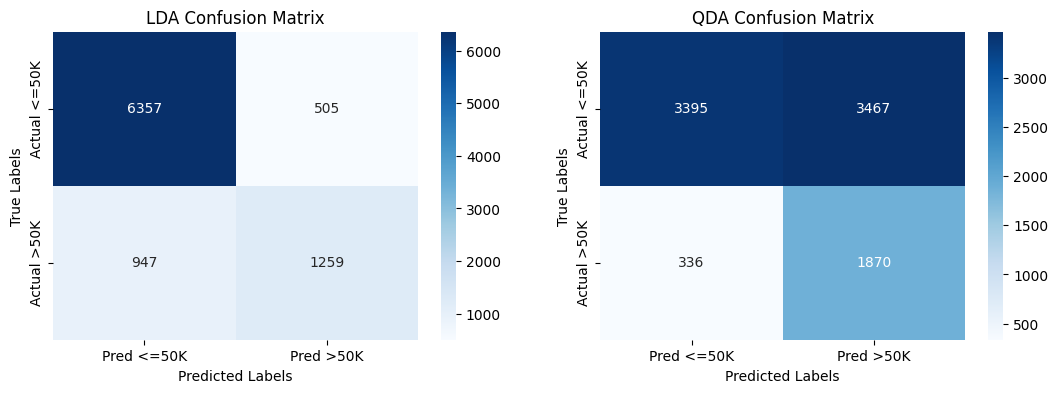

In [8]:
# Plotting the confusion matrices   
# Add figure
plt.figure(figsize=(20, 4))

# LDA confusion matrix
plt.subplot(1,3,1)
sns.heatmap(lda_conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Pred <=50K', 'Pred >50K'], 
                yticklabels=['Actual <=50K', 'Actual >50K'])
plt.title('LDA Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# QDA confusion matrix
plt.subplot(1,3,2)
sns.heatmap(qda_conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Pred <=50K', 'Pred >50K'], 
                yticklabels=['Actual <=50K', 'Actual >50K'])
plt.title('QDA Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.show()

The accuracies and confusion matrices show clearly that the LDA significantly outperformsthe QDA model due to the higher accuracies and higher frequencies of true positives and true negatives.

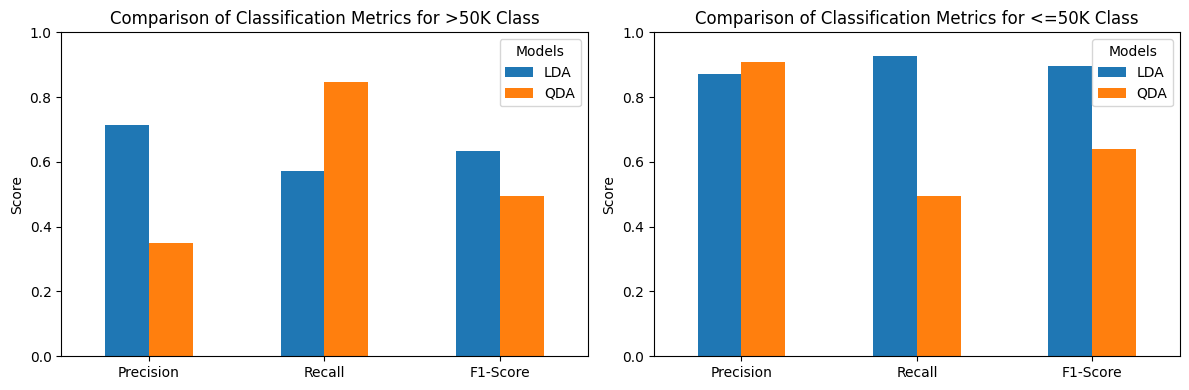

In [9]:
# Create DataFrames for the >50K and <=50K classification reports
comparison_df_high = pd.DataFrame({
    'LDA': [lda_report['>50K']['precision'], lda_report['>50K']['recall'], lda_report['>50K']['f1-score']],
    'QDA': [qda_report['>50K']['precision'], qda_report['>50K']['recall'], qda_report['>50K']['f1-score']],
}, index=['Precision', 'Recall', 'F1-Score'])

comparison_df_low = pd.DataFrame({
    'LDA': [lda_report['<=50K']['precision'], lda_report['<=50K']['recall'], lda_report['<=50K']['f1-score']],
    'QDA': [qda_report['<=50K']['precision'], qda_report['<=50K']['recall'], qda_report['<=50K']['f1-score']],
}, index=['Precision', 'Recall', 'F1-Score'])

# Add figure
plt.figure(figsize=(12, 4))

# Plot for >50K class
plt.subplot(1, 2, 1)
comparison_df_high.plot(kind='bar', ax=plt.gca())
plt.title('Comparison of Classification Metrics for >50K Class')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title='Models')

# Plot for <=50K class
plt.subplot(1, 2, 2)
comparison_df_low.plot(kind='bar', ax=plt.gca())
plt.title('Comparison of Classification Metrics for <=50K Class')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title='Models')

# Show plots
plt.tight_layout()
plt.show()

The barplots show that for the lower income '<50K' class, both models are precise, however, due to the significantly lower recall value for the QDA model, the F1-scores of the LDA model is much higher.
For the higher income '>50K' class, the LDA model also has a higher F1-score than the QDA.
This strongly suggests that the LDA outperforms the QDA model. We will investigate their receiver-operator curves to make a final conlcusion about the most suitable model.

## Receiver Operator Curves

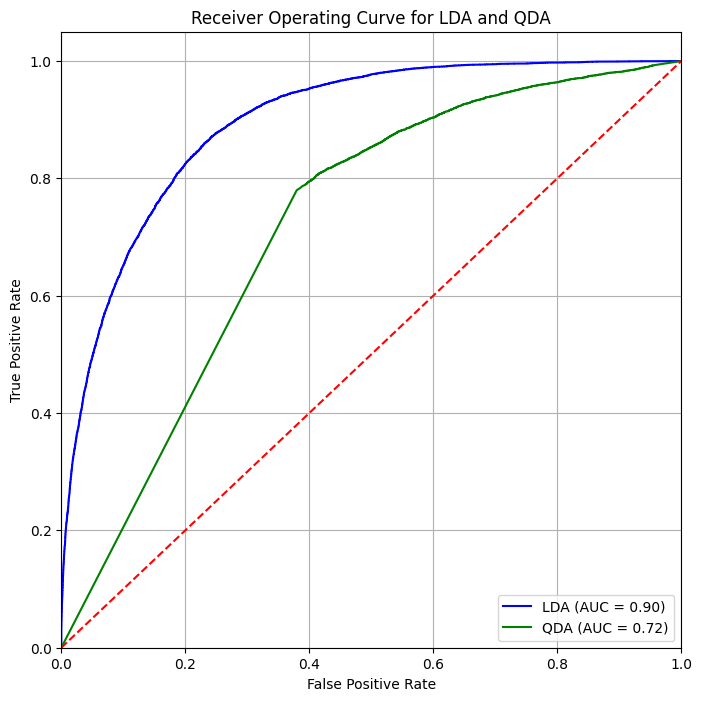

In [11]:
# Get predicted probabilities for LDA
y_pred_prob_lda = lda.predict_proba(X_train_scaled)[:,1]
fpr_lda, tpr_lda, _ = roc_curve(y_train_array, y_pred_prob_lda, pos_label='>50K')
roc_auc_lda = auc(fpr_lda, tpr_lda)

# Get predicted probabilities for QDA
y_pred_prob_qda = qda.predict_proba(X_train_scaled)[:,1]
fpr_qda, tpr_qda, _ = roc_curve(y_train_array, y_pred_prob_qda, pos_label='>50K')
roc_auc_qda = auc(fpr_qda, tpr_qda)

# import pickle

# # Prepare data to save in pickle format
# lda_roc_data = {
#     'fpr_lda': fpr_lda,
#     'tpr_lda': tpr_lda,
#     'roc_auc_lda': roc_auc_lda
# }

# # Save LDA ROC data to pickle file
# file_path = "pickle/LDA_roc_data.pkl"
# with open(file_path, 'wb') as file:
#     pickle.dump(lda_roc_data, file)

# Plot ROC curves for both LDA and QDA
plt.figure(figsize=(8, 8))
plt.plot(fpr_lda, tpr_lda, color='blue', label=f'LDA (AUC = {roc_auc_lda:.2f})')
plt.plot(fpr_qda, tpr_qda, color='green', label=f'QDA (AUC = {roc_auc_qda:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Curve for LDA and QDA')
plt.legend(loc='lower right')
plt.grid()
plt.show()

We can see that the LDA curve dominates the QDA curve and has a much high Area Under Curve (AUC) value. This supports our analysis that LDA is much more suitable and performs better for our data than QDA.

## Conclusion
It is evident that out of the two modles, linear dsicriminant anlysis is much more successful in classifying our income data. The significantly higher accuracy, as well as higher F1-score give evidence for this along with the receiver-operator curve. The model still has room for improvement since it classified a large number of higher income people as lower income, perhaps due to some model bias due to the imbalanced dataset. We will investigate methods to improve our models next.

## References
[1] Hastie, Trevor, et al. The elements of statistical learning: data mining, inference, and prediction. Vol. 2. New York: springer, 2009.

[2] Research Method Article: https://researchmethod.net/discriminant-analysis/

[3] scikit-learn Documentation - 1.2 Linear and Quadratic Discriminant Analysis: https://scikit-learn.org/stable/modules/lda_qda.html

[4] scikit-learn Documenation - 6.3 Preprocessing data: https://scikit-learn.org/stable/modules/preprocessing.html

[5] sckit-learn Documentation - 3.4 Metrics and scoring: https://scikit-learn.org/stable/modules/model_evaluation.html#

[5] Sebastian Raschka’s PCA vs LDA article with Python Examples: https://sebastianraschka.com/Articles/2014_python_lda.html#lda-via-scikit-learn

[6] Data Science Toolbox Lecture Notes on ROC Curves: https://dsbristol.github.io/dst/assets/slides/05.1-Classification.pdf

[7] scikit-learn GitHub RDA Implementation: https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/discriminant_analysis.py